Analyzing ADWIN Data

In [4]:
import random
from river import drift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Look at EDDM next

In [6]:
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

In [ ]:
avg_engagement.index[0]

Timestamp('2024-01-01 00:00:00')

In [ ]:
time_a_df.drop(columns=['Unnamed: 0'],inplace=True)
time_b_decay_df.drop(columns=['Unnamed: 0'],inplace=True)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'], format='%Y-%m-%d')
time_b_decay_df['Date'] = pd.to_datetime(time_b_decay_df['Date'], format='%Y-%m-%d')

In [ ]:
date = np.unique(time_a_df['Date']).astype('datetime64[D]')

engagement = time_a_df['Engagement']
ctr = time_a_df['CTR']
all_data = pd.concat([time_a_df,time_b_decay_df],axis=0)


all_ctr = all_data['CTR']
all_engagement = all_data['Engagement']


avg_ctr = all_data.groupby('Date')['CTR'].mean()
avg_engagement = all_data.groupby('Date')['Engagement'].mean()

In [112]:
product_launch_date = np.max(np.unique(time_a_df['Date']).astype('datetime64[D]'))

In [116]:
product_launch_date.dtype

dtype('<M8[D]')

In [113]:
delay_calculator(product_launch_date, change_points)

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('int32') and dtype('<M8[D]')

In [ ]:
change_points[0][0]

AttributeError: 'int' object has no attribute 'dtype'

In [131]:
change_points_avg[0][0]

Timestamp('2024-01-05 00:00:00')

In [ ]:
def delay_calculator(product_launch_date, change_points):
    earliest_detection = min([val[0] for val in change_points])
    delay = earliest_detection - product_launch_date
    return delay

In [ ]:
delta_range = [.25, .15, .05, .02, .01, .005, .002, .001]
min_window_length_range = [1,2,5,10,15,20]

array([1.00230524, 1.01410198, 1.02603757, 1.03811364, 1.05033184,
       1.06269384, 1.07520134, 1.08785604, 1.10065969, 1.11361403,
       1.12672084, 1.13998191, 1.15339906, 1.16697412, 1.18070896,
       1.19460544, 1.20866549, 1.22289102, 1.23728397, 1.25184633,
       1.26658008, 1.28148724, 1.29656985, 1.31182998, 1.32726971,
       1.34289116, 1.35869648, 1.37468781, 1.39086736, 1.40723733,
       1.42379997, 1.44055755, 1.45751236, 1.47466671, 1.49202297,
       1.50958351, 1.52735073, 1.54532706, 1.56351496, 1.58191693,
       1.60053548, 1.61937317, 1.63843257, 1.65771629, 1.67722697,
       1.69696728, 1.71693993, 1.73714766, 1.75759321, 1.77827941])

In [124]:
avg_target

Date
2024-01-01    54.665251
2024-01-02    55.372772
2024-01-03    56.205188
2024-01-04    54.979850
2024-01-05    54.604444
                ...    
2024-12-27    54.100384
2024-12-28    52.973012
2024-12-29    53.600603
2024-12-30    54.106290
2024-12-31    54.235546
Name: Engagement, Length: 366, dtype: float64

In [ ]:
# Metric # of false positives
# Metric delay 

In [125]:

delta_range = [.25, .15, .05, .02, .01, .005, .002, .001]
min_window_length_range = [1,2,5,10,15,20]




adwin = drift.ADWIN(delta = .05, # significance value
                    clock=1, # how often ADWIN should check for changes
                    min_window_length=5, #Min length allowerd when checking concept drift, smaller may decrease delay but lead to false positives
                    grace_period=0) #when to start looking




df = all_data
target_column = 'Engagement'
all_dates = np.unique(all_data['Date']).astype('datetime64[D]')

def adwin_tests(adwin_model, df, target_column):
    avg_target = df.groupby('Date')[target_column].mean()
    median_target = df.groupby('Date')[target_column].median()
    all_dates = np.unique(df['Date']).astype('datetime64[D]')

    
    change_points_avg = []
    for date, val in avg_target.items():
        adwin_model.update(val)
        if adwin_model.drift_detected:
            print(f"Change detected at {date}, input value: {val}")
    #        print(adwin.n_detections)
            change_points_avg.append((date,val))
    print(adwin_model.estimation)
    print(adwin_model.variance)

    change_points_median = []
    for date, val in median_target.items():
        adwin_model.update(val)
        if adwin_model.drift_detected:
            print(f"Change detected at {date}, input value: {val}")
    #        print(adwin.n_detections)
            change_points_median.append((date,val))
    print(adwin_model.estimation)
    print(adwin_model.variance)


    plt.figure(figsize=(12, 6))
    sns.lineplot(x=avg_target.index, y=avg_target, label=f"{target_column} (Average)")
    sns.lineplot(x=avg_target.index, y=median_target, label=f"{target_column} (Median)")
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")

    for date, val in change_points_avg:
        plt.annotate(
            f"Change detected\n(index {date})", 
            xy=(date, val), 
            #xytext=(date + 10, val + 5),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9,
            backgroundcolor='white'
        )

    for date, val in change_points_median:
        plt.annotate(
            f"Change detected\n(index {date})", 
            xy=(date, val), 
            #xytext=(date + 10, val + 5),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9,
            backgroundcolor='white'
        )    

    plt.xlabel("Date")
    plt.ylabel(target_column)
    plt.title("Data Stream with Change Detection Points")
    plt.legend()
    plt.show()

    # delay_avg = delay_calculator(time_a_df.index[-1], change_points_avg)
    # delay_median = delay_calculator(time_a_df.index[-1], change_points_median)

    return change_points_avg, change_points_median #,delay_avg, delay_median


[(Timestamp('2024-01-05 00:00:00'), 54.60444366056621),
 (Timestamp('2024-09-16 00:00:00'), 54.256293992777444),
 (Timestamp('2024-12-10 00:00:00'), 53.2340165302796)]

Change detected at 2024-01-05 00:00:00, input value: 54.60444366056621
Change detected at 2024-09-16 00:00:00, input value: 54.256293992777444
Change detected at 2024-12-10 00:00:00, input value: 53.2340165302796
53.956391107392726
4.489824165420543
Change detected at 2024-01-10 00:00:00, input value: 49.09564070204681
Change detected at 2024-10-16 00:00:00, input value: 48.31673576739372
49.41885313702929
39.06807662623548


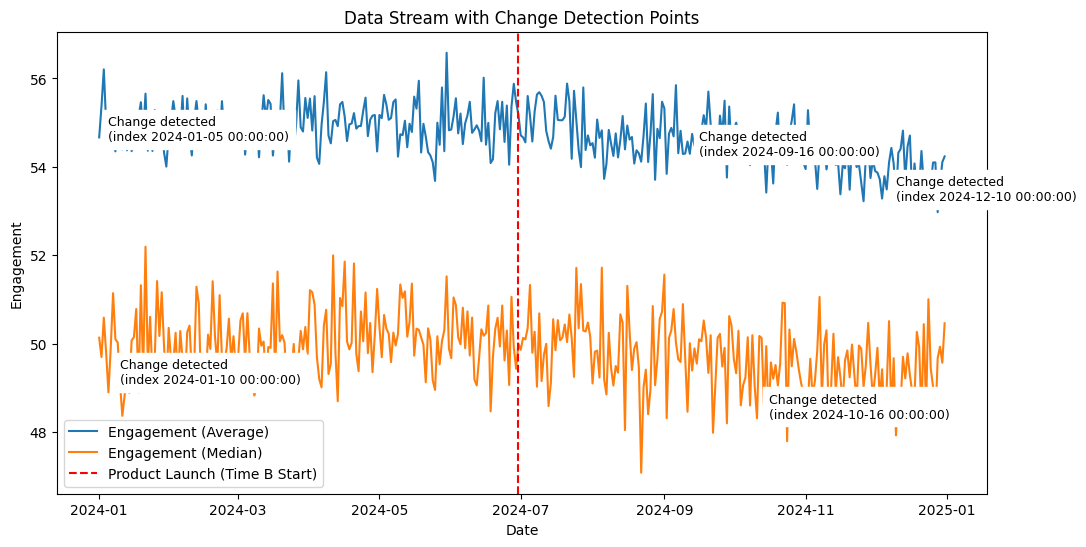

In [127]:
change_points_avg, change_points_median = adwin_tests(adwin, all_data, 'Engagement')

<Axes: ylabel='Engagement'>

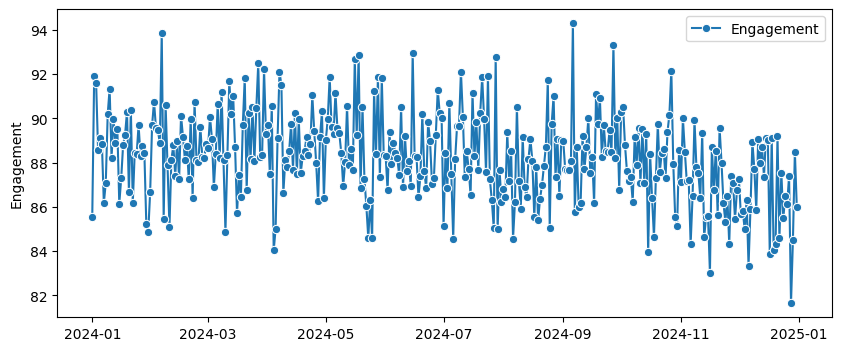

In [96]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=all_dates, y=avg_engagement, marker="o", label="Engagement")

In [44]:
user_groups = {user_id: group for user_id, group in all_data.groupby('Group')}
# Groups are split properly, have their own distributions

user_groups.items()

dict_items([('Baseline',             Date    UserID     Group  Engagement       CTR
0     2024-01-01  U0000000  Baseline   64.355985  0.010571
1     2024-01-02  U0000000  Baseline   58.951726  0.021496
2     2024-01-03  U0000000  Baseline   59.145322  0.024909
3     2024-01-04  U0000000  Baseline   57.894817  0.030044
4     2024-01-05  U0000000  Baseline   64.660806  0.017958
...          ...       ...       ...         ...       ...
18027 2024-12-27  U0000097  Baseline   47.834010  0.030608
18028 2024-12-28  U0000097  Baseline   44.888605  0.014360
18029 2024-12-29  U0000097  Baseline   47.966263  0.028009
18030 2024-12-30  U0000097  Baseline   49.530669  0.037369
18031 2024-12-31  U0000097  Baseline   44.714414  0.020020

[20862 rows x 5 columns]), ('Drifters',             Date    UserID     Group  Engagement       CTR
1092  2024-01-01  U0000006  Drifters   40.399867  0.046888
1093  2024-01-02  U0000006  Drifters   38.014492  0.019678
1094  2024-01-03  U0000006  Drifters   37.958564 

In [ ]:
#user_groups['Baseline'] = user_groups['Baseline'].reset_index


In [45]:
user_groups['Baseline'].columns

Index(['Date', 'UserID', 'Group', 'Engagement', 'CTR'], dtype='object')

In [ ]:
user_groups['Baseline'].groupby('Date')['Engagement'].mean()

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

Change detected at index 288, input value: 48.402587548652285
1
48.65819601478764
11.993194062541216
Baseline ADWIN window width: 77.0



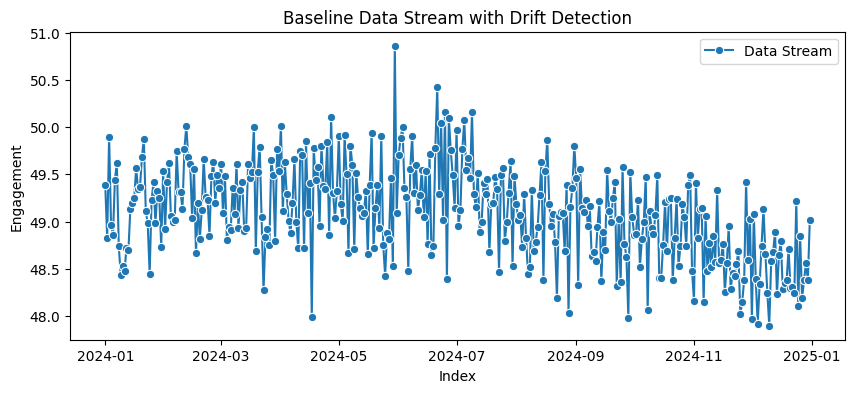

Change detected at index 314, input value: 38.18465455200966
1
39.065788786704296
20.91910521651391
Drifters ADWIN window width: 51.0



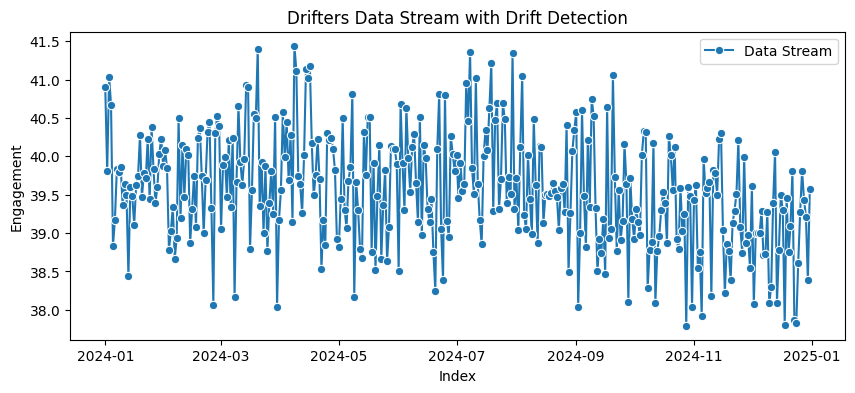

Change detected at index 330, input value: 84.32861766447058
1
86.5276984193086
122.23771076173668
Power Users ADWIN window width: 35.0



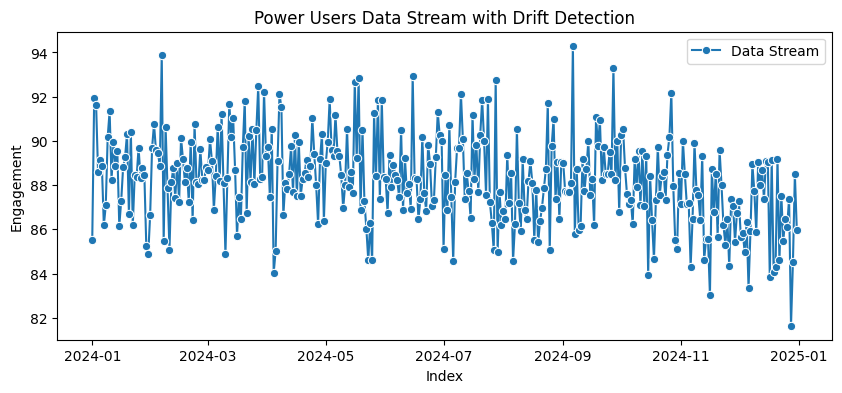

In [61]:
for group_name, group in user_groups.items():
    
#    group_dates = np.unique(group.groupby('Date')).astype('datetime64[D]')
    #avg_ctr = group.groupby('Date')['CTR'].mean()
    avg_engagement = group.groupby('Date')['Engagement'].mean()
    group_dates = avg_engagement.index

    #group.set_index(group['Date'],inplace=True)

    #WANT TO ADJUST THIS ADWIN
    adwin_by_group = drift.ADWIN(delta = .01,
                    clock=1,
                    min_window_length=1,
                    grace_period=5) # Create a new ADWIN instance for this user
    
    change_points = []  # To store (index, value) for detected drifts

    data_stream = list(avg_engagement)

    change_points = []
    for i, val in enumerate(data_stream):
        adwin_by_group.update(val)
        if adwin_by_group.drift_detected:
            print(f"Change detected at index {i}, input value: {val}")
            print(adwin_by_group.n_detections)
            change_points.append((i,val))
    print(adwin_by_group.estimation)
    print(adwin_by_group.variance)

    # Optionally, print ADWIN's current window length
    print(f"{group_name} ADWIN window width: {adwin_by_group.width}\n")

    # Plot the user's data stream using Seaborn.
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=group_dates, y=avg_engagement, marker="o", label="Data Stream")

    # Annotate each detected change point.
    for idx, val in change_points:
        plt.annotate(
            f"Change at {idx}", 
            xy=(idx, val), 
            xytext=(idx, val + 1),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9
        )

    plt.title(f"{group_name} Data Stream with Drift Detection")
    plt.xlabel("Index")
    plt.ylabel("Engagement")
    plt.legend()
    plt.show()